In [40]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

In [41]:
# Parameters (matching MATLAB and GCN script where applicable)
num_instances = 100  # Or 1000, depending on your dataset
num_anchors = 16 # As per your current selection
num_unknowns = 48 # As per your current selection
total_nodes = num_anchors + num_unknowns

num_measurements = 10 # Number of RSSI measurements per node pair from MATLAB script

# Map origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

# Adjust this path if your data is elsewhere
matlab_data_base_path = "../matlab/data/64beacons_100instances/" # As per your current selection
output_dir = "output_visualizations_matlab_im"
os.makedirs(output_dir, exist_ok=True)

# --- Create unique identifiers for output files ---
# Extract a dataset name from the path (e.g., "mid_16beacons")
dataset_name = os.path.basename(os.path.normpath(matlab_data_base_path))
# Create a node configuration string (e.g., "16N_4A")
node_config_str = f"{total_nodes}N_{num_anchors}A"
# --- End unique identifiers ---

In [42]:
# Utility Functions
def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

def rssi_to_distance_log_model(rssi, A_param, n_param):
    """Converts RSSI to distance using the log-distance path loss model.
    RSSI(d) = A_param - 10 * n_param * log10(d)
    log10(d) = (A_param - RSSI(d)) / (10 * n_param)
    d = 10**((A_param - RSSI(d)) / (10 * n_param))
    
    Args:
        rssi (float): Received Signal Strength Indicator.
        A_param (float): RSSI at a reference distance of 1 meter (dBm).
        n_param (float): Path loss exponent.
    Returns:
        float: Estimated distance in meters.
    """
    # Add a small epsilon to rssi if it's too close to A_param to avoid log10(0) or large numbers if n_param is small
    epsilon_rssi = 1e-6 
    if n_param == 0: # Avoid division by zero
        return float('inf') # Or handle as an error/invalid parameter
    
    power_val = (A_param - (rssi + epsilon_rssi)) / (10 * n_param)
    
    # Cap power_val to prevent overflow if (A_param - rssi) is very large
    # For example, if power_val > 30 (10^30 meters), it's likely an outlier.
    if power_val > 30: # Corresponds to 10^30 meters, which is astronomically large
        return float('inf') # Or a very large, but finite number like 1e5 meters (100km)
        
    distance = 10**power_val
    return distance

In [43]:
from scipy.optimize import curve_fit

def log_distance_model_for_fit(d, A, n):
    """Model function for curve_fit: RSSI = A - 10*n*log10(d)"""
    # Ensure d is positive to avoid log10(0) or log10(negative)
    d_safe = np.maximum(d, 1e-9) # Avoid d=0, use a very small number instead (e.g., 1mm)
    return A - 10 * n * np.log10(d_safe)

def estimate_rssi_parameters(anchor_positions_xy, anchor_rssi_matrix):
    """
    Estimates RSSI model parameters A and n using anchor-to-anchor measurements.
    Args:
        anchor_positions_xy (np.array): Nx2 array of known X,Y positions of N anchors.
        anchor_rssi_matrix (np.array): NxN_orig_measurements array of RSSI values between anchors.
                                        (e.g., N_orig_measurements could be num_measurements)
    Returns:
        tuple: (A_est, n_est) - Estimated A and n parameters.
               Returns (None, None) if estimation fails.
    """
    distances = []
    avg_rssis = []
    num_current_anchors = anchor_positions_xy.shape[0]

    for i in range(num_current_anchors):
        for j in range(i + 1, num_current_anchors): # Use i+1 to avoid duplicates and self-loops
            dist_ij = np.linalg.norm(anchor_positions_xy[i] - anchor_positions_xy[j])
            if dist_ij == 0: # Should not happen if i != j
                continue

            # Assuming anchor_rssi_matrix is (num_anchors, num_anchors, num_measurements)
            # Or if it's pre-averaged: (num_anchors, num_anchors)
            if anchor_rssi_matrix.ndim == 3:
                rssi_ij_measurements = anchor_rssi_matrix[i, j, :]
                rssi_ji_measurements = anchor_rssi_matrix[j, i, :]
                
                # Filter out NaNs before averaging if any
                valid_rssi_ij = rssi_ij_measurements[~np.isnan(rssi_ij_measurements)]
                valid_rssi_ji = rssi_ji_measurements[~np.isnan(rssi_ji_measurements)]
                
                if len(valid_rssi_ij) > 0:
                    avg_rssis.append(np.mean(valid_rssi_ij))
                    distances.append(dist_ij)
                if len(valid_rssi_ji) > 0: # If measurements are directional and different
                    avg_rssis.append(np.mean(valid_rssi_ji))
                    distances.append(dist_ij) # distance is symmetric
            elif anchor_rssi_matrix.ndim == 2: # Assumes already averaged or single measurement
                 rssi_ij = anchor_rssi_matrix[i,j]
                 rssi_ji = anchor_rssi_matrix[j,i] # Could be symmetric
                 if not np.isnan(rssi_ij):
                    avg_rssis.append(rssi_ij)
                    distances.append(dist_ij)
                 if i !=j and not np.isnan(rssi_ji) and rssi_ij != rssi_ji : # if not symmetric and not already added
                    avg_rssis.append(rssi_ji)
                    distances.append(dist_ij)


    if len(distances) < 2: # Need at least 2 points to fit A and n
        # print("Warning: Not enough valid anchor-to-anchor measurements to estimate RSSI parameters.")
        # Fallback to default/placeholder values if too few points
        return -50.0, 3.0 # Or raise an error

    distances = np.array(distances)
    avg_rssis = np.array(avg_rssis)

    # Bounds for A (e.g., -100 to 50 dBm) and n (e.g., 1.5 to 6)
    # These bounds help curve_fit find more realistic parameters.
    # A is RSSI at 1m. For typical indoor/outdoor, it's often negative.
    # n (path loss exponent) typically ranges from 2 (free space) to 4-6 (obstructed).
    param_bounds = ([-100, 1.5], [50, 6.0])
    
    # Initial guess for A and n
    # A can be roughly the max RSSI observed, n can be 2-3.
    p0 = [np.max(avg_rssis) if len(avg_rssis) > 0 else -50.0, 3.0]


    try:
        params, covariance = curve_fit(log_distance_model_for_fit, distances, avg_rssis, p0=p0, bounds=param_bounds, maxfev=5000)
        A_est, n_est = params
        # Add checks for reasonableness of estimated parameters
        if not (param_bounds[0][0] <= A_est <= param_bounds[1][0] and \
                param_bounds[0][1] <= n_est <= param_bounds[1][1]):
            # print(f"Warning: Estimated RSSI parameters {A_est, n_est} are outside typical bounds. Falling back.")
            return -50.0, 3.0 # Fallback
        return A_est, n_est
    except RuntimeError:
        # print("Warning: curve_fit failed to converge for RSSI parameter estimation. Falling back to defaults.")
        return -50.0, 3.0 # Fallback to default values
    except ValueError as e:
        # print(f"Warning: ValueError during RSSI parameter estimation: {e}. Falling back to defaults.")
        return -50.0, 3.0 # Fallback

In [44]:
def load_matlab_instance(instance_idx, base_path=matlab_data_base_path):
    """Loads data for a single MATLAB instance."""
    filename = os.path.join(base_path, f"data_instance_{instance_idx}.mat")
    try:
        mat_data = loadmat(filename)
    except FileNotFoundError:
        print(f"Error: File not found {filename}")
        return None, None, None

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    # signal_strength_matrix shape from MATLAB: (totalNodes, totalNodes, numSimulations)
    signal_strength_matrix_all_sims = mat_data['signal_strength_matrix']
    
    # Average RSSI across simulations for simplicity in this multilateration model
    # Or, one could use all measurements and treat them as distinct inputs to LS
    # For now, let's average. The GCN model also seems to average or use all (needs check)
    # GCN script: measured_RSSI = data.edge_attr.mean(dim=1) -> averages over num_measurements
    rssi_matrix_avg = np.nanmean(signal_strength_matrix_all_sims, axis=2)


    num_nodes_in_instance = len(nodeLatitudes)
    if num_nodes_in_instance != total_nodes:
        print(f"Warning: Instance {instance_idx} has {num_nodes_in_instance} nodes, expected {total_nodes}.")
        # Decide how to handle this: skip, error, or adapt. For now, let's try to adapt.
    
    node_positions_xy = np.zeros((num_nodes_in_instance, 2))
    for i in range(num_nodes_in_instance):
        node_positions_xy[i, 0], node_positions_xy[i, 1] = latlon_to_xy(
            nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon
        )
        
    return node_positions_xy, rssi_matrix_avg, signal_strength_matrix_all_sims

In [45]:
def multilateration_error_func(position_guess, known_positions, measured_distances):
    """
    Error function for least_squares multilateration.
    Args:
        position_guess (np.array): Current [x, y] guess for the unknown node.
        known_positions (np.array): Kx2 array of known neighbor positions.
        measured_distances (np.array): K-element array of measured distances to neighbors.
    Returns:
        np.array: K-element array of errors (calculated_dist - measured_dist).
    """
    errors = []
    for i in range(known_positions.shape[0]):
        calculated_dist = np.linalg.norm(position_guess - known_positions[i])
        errors.append(calculated_dist - measured_distances[i])
    return np.array(errors)

def estimate_unknown_position_ls(initial_guess_xy, neighbor_positions_xy, neighbor_rssi_values, A_param, n_param):
    """
    Estimates the position of an unknown node using least squares multilateration.
    Args:
        initial_guess_xy (np.array): Initial [x,y] guess for the unknown node.
        neighbor_positions_xy (list of np.array): List of [x,y] for known neighbor positions.
        neighbor_rssi_values (list of float): List of average RSSI values from neighbors.
        A_param (float): Instance-specific RSSI model parameter A.
        n_param (float): Instance-specific RSSI model parameter n.
    Returns:
        np.array: Estimated [x,y] position or None if estimation fails.
    """
    if len(neighbor_positions_xy) < 2: # Need at least 2 for 2D, 3 for less ambiguity
        # print("Warning: Fewer than 2 neighbors for multilateration.")
        return None 

    measured_distances = [rssi_to_distance_log_model(rssi, A_param, n_param) for rssi in neighbor_rssi_values]
    
    # Filter out inf distances which can happen if RSSI is too low / params are off
    valid_indices = [i for i, d in enumerate(measured_distances) if np.isfinite(d) and d < 1e4] # Cap max distance e.g. 10km
    
    if len(valid_indices) < 2:
        # print("Warning: Fewer than 2 valid distance measurements after filtering.")
        return None
        
    known_pos_filtered = np.array([neighbor_positions_xy[i] for i in valid_indices])
    measured_dist_filtered = np.array([measured_distances[i] for i in valid_indices])

    if known_pos_filtered.shape[0] < 2: # Still need at least 2 points
        return None

    # Bounds for x, y (e.g., based on map size if known, otherwise can be loose)
    # Assuming the MATLAB script's mapSizeMeters = 4000
    # And positions are relative to origin, so roughly 0 to 4000.
    # Looser bounds: -1000 to 5000 for some margin
    bounds = ([-1000, -1000], [5000, 5000]) 


    result = least_squares(
        multilateration_error_func,
        initial_guess_xy,
        args=(known_pos_filtered, measured_dist_filtered),
        bounds=bounds,
        method='trf', # Trust Region Reflective, good for bounds
        ftol=1e-5, xtol=1e-5, gtol=1e-5 # Tighter tolerances
    )

    if result.success : #and result.cost < 1e3: # Add a cost check if needed
        return result.x
    else:
        # print(f"Warning: Least squares optimization failed. Status: {result.status}, Message: {result.message}")
        return None

Processing Instances:   0%|          | 0/100 [00:00<?, ?it/s]/var/folders/j4/pbwqtc3x6f964s_k6q48jskh0000gn/T/ipykernel_6762/2499881170.py:19: RuntimeWarning: Mean of empty slice
  rssi_matrix_avg = np.nanmean(signal_strength_matrix_all_sims, axis=2)
Processing Instances: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


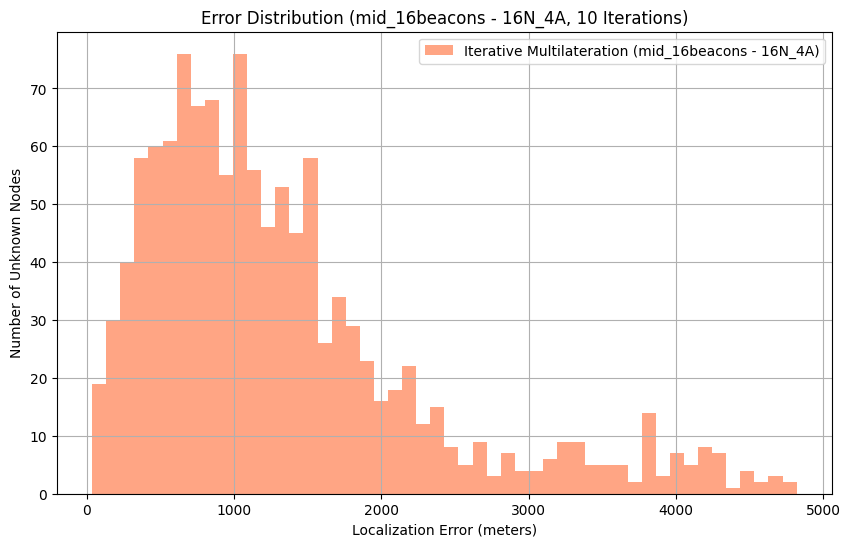

Iterative Multilateration (mid_16beacons - 16N_4A - 10 iterations):
  Mean Error: 1325.3830 m
  Median Error: 1075.0209 m
  Std Dev Error: 967.0943 m


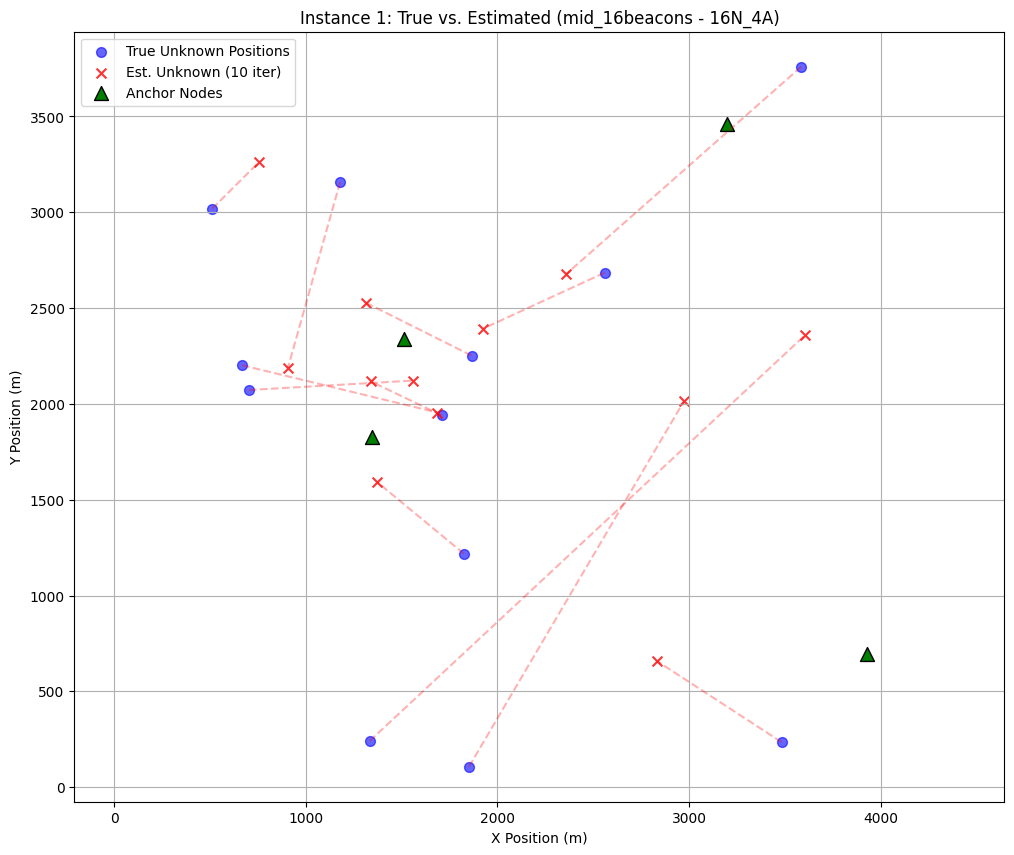

In [46]:
all_instance_errors = []
num_iterations = 10 # Number of iterations for the iterative multilateration

for idx_instance in tqdm(range(1, num_instances + 1), desc="Processing Instances"):
    node_positions_xy_true, rssi_matrix_avg_true, _ = load_matlab_instance(idx_instance)
    if node_positions_xy_true is None:
        continue

    true_anchor_positions_xy = node_positions_xy_true[:num_anchors]
    
    anchor_to_anchor_rssi_matrix = rssi_matrix_avg_true[:num_anchors, :num_anchors]
    
    A_inst, n_inst = estimate_rssi_parameters(true_anchor_positions_xy, anchor_to_anchor_rssi_matrix)
    
    if A_inst is None or n_inst is None:
        A_inst, n_inst = -50.0, 3.0 

    estimated_positions_xy = np.copy(node_positions_xy_true) 
    avg_anchor_pos = np.mean(true_anchor_positions_xy, axis=0)
    for i in range(num_anchors, total_nodes):
        estimated_positions_xy[i] = avg_anchor_pos + np.random.randn(2) * 10 
    
    current_estimated_positions_for_iter = np.copy(estimated_positions_xy)

    for iteration in range(num_iterations):
        newly_estimated_positions_this_iter = np.copy(current_estimated_positions_for_iter)
        
        for i_unknown in range(num_anchors, total_nodes):
            neighbor_pos_for_mlat = []
            neighbor_rssi_for_mlat = []
            
            for j_known in range(total_nodes):
                if i_unknown == j_known:
                    continue
                
                rssi_val = rssi_matrix_avg_true[i_unknown, j_known] 
                
                if not np.isnan(rssi_val) and np.isfinite(rssi_val):
                    neighbor_pos_for_mlat.append(current_estimated_positions_for_iter[j_known])
                    neighbor_rssi_for_mlat.append(rssi_val)
            
            if len(neighbor_pos_for_mlat) >= 3: 
                initial_guess = current_estimated_positions_for_iter[i_unknown] 
                
                estimated_pos = estimate_unknown_position_ls(
                    initial_guess,
                    neighbor_pos_for_mlat,
                    neighbor_rssi_for_mlat,
                    A_inst,
                    n_inst
                )
                if estimated_pos is not None:
                    newly_estimated_positions_this_iter[i_unknown] = estimated_pos
        
        current_estimated_positions_for_iter = np.copy(newly_estimated_positions_this_iter)

    instance_node_errors = []
    for i in range(num_anchors, total_nodes):
        true_pos = node_positions_xy_true[i]
        est_pos = current_estimated_positions_for_iter[i]
        error = np.linalg.norm(true_pos - est_pos)
        instance_node_errors.append(error)
    all_instance_errors.extend(instance_node_errors) # Corrected this line

# --- Plotting and Final Evaluation ---
all_instance_errors = np.array(all_instance_errors)

plt.figure(figsize=(10, 6))
plt.hist(all_instance_errors, bins=50, alpha=0.7, color='coral', label=f'Iterative Multilateration ({dataset_name} - {node_config_str})') # Updated label
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Unknown Nodes')
plt.title(f'Error Distribution ({dataset_name} - {node_config_str}, {num_iterations} Iterations)') # Updated title
plt.legend()
plt.grid(True)
# Updated savefig line for histogram
plt.savefig(os.path.join(output_dir, f"{dataset_name}_{node_config_str}_im_error_histogram.png"))
plt.show()

mean_error_im_matlab = np.mean(all_instance_errors) if len(all_instance_errors) > 0 else float('nan')
median_error_im_matlab = np.median(all_instance_errors) if len(all_instance_errors) > 0 else float('nan')
std_error_im_matlab = np.std(all_instance_errors) if len(all_instance_errors) > 0 else float('nan')

print(f"Iterative Multilateration ({dataset_name} - {node_config_str} - {num_iterations} iterations):") # Updated print
print(f"  Mean Error: {mean_error_im_matlab:.4f} m")
print(f"  Median Error: {median_error_im_matlab:.4f} m")
print(f"  Std Dev Error: {std_error_im_matlab:.4f} m")

# Optional: Visualize one instance
if num_instances > 0:
    instance_to_viz = 1 
    node_pos_true_viz, rssi_avg_viz, _ = load_matlab_instance(instance_to_viz, base_path=matlab_data_base_path) # pass base_path
    if node_pos_true_viz is not None:
        true_anchor_pos_viz = node_pos_true_viz[:num_anchors]
        anchor_rssi_matrix_viz = rssi_avg_viz[:num_anchors, :num_anchors]
        A_viz, n_viz = estimate_rssi_parameters(true_anchor_pos_viz, anchor_rssi_matrix_viz)
        if A_viz is None: A_viz, n_viz = -50.0, 3.0

        est_pos_viz = np.copy(node_pos_true_viz)
        avg_anchor_viz = np.mean(true_anchor_pos_viz, axis=0)
        for i in range(num_anchors, total_nodes):
            est_pos_viz[i] = avg_anchor_viz + np.random.randn(2) * 10
            
        current_est_pos_viz_iter = np.copy(est_pos_viz)
        for _ in range(num_iterations):
            newly_est_pos_viz_this_iter = np.copy(current_est_pos_viz_iter)
            for i_unknown in range(num_anchors, total_nodes):
                neighbors_p = []
                neighbors_r = []
                for j_known in range(total_nodes):
                    if i_unknown == j_known: continue
                    rssi_val = rssi_avg_viz[i_unknown, j_known]
                    if not np.isnan(rssi_val) and np.isfinite(rssi_val):
                        neighbors_p.append(current_est_pos_viz_iter[j_known])
                        neighbors_r.append(rssi_val)
                if len(neighbors_p) >= 3:
                    est_p = estimate_unknown_position_ls(current_est_pos_viz_iter[i_unknown], neighbors_p, neighbors_r, A_viz, n_viz)
                    if est_p is not None:
                        newly_est_pos_viz_this_iter[i_unknown] = est_p
            current_est_pos_viz_iter = newly_est_pos_viz_this_iter
        
        final_estimated_pos_viz = current_est_pos_viz_iter

        plt.figure(figsize=(12, 10))
        plt.scatter(node_pos_true_viz[num_anchors:, 0], node_pos_true_viz[num_anchors:, 1], c='blue', label='True Unknown Positions', alpha=0.6, s=50)
        plt.scatter(final_estimated_pos_viz[num_anchors:, 0], final_estimated_pos_viz[num_anchors:, 1], c='red', marker='x', label=f'Est. Unknown ({num_iterations} iter)', alpha=0.8, s=50)
        plt.scatter(node_pos_true_viz[:num_anchors, 0], node_pos_true_viz[:num_anchors, 1], c='green', marker='^', s=100, label='Anchor Nodes', edgecolors='black')

        for i in range(num_anchors, total_nodes):
            plt.plot([node_pos_true_viz[i,0], final_estimated_pos_viz[i,0]], [node_pos_true_viz[i,1], final_estimated_pos_viz[i,1]], 'r--', alpha=0.3)
        
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.title(f'Instance {instance_to_viz}: True vs. Estimated ({dataset_name} - {node_config_str})') # Updated title
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        # Updated savefig line for instance visualization
        plt.savefig(os.path.join(output_dir, f"{dataset_name}_{node_config_str}_im_instance_{instance_to_viz}_visualization.png"))
        plt.show()